In [255]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from dfa import dfa

In [256]:
df = p.load(open('total.p','rb'))
likert = pd.read_csv('likert.csv', header = None).T
likert = likert.set_index(np.arange(11,45)).drop(25)

In [257]:
all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

In [258]:
# Book-keeping Functions
n_splits = 25

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return df.loc[measure, epoch][num_to_subject(subjno)][:,0]
    elif isinstance(epoch, int):
        return df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)][:,0]

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(df.loc[measure, epoch][num_to_subject(subjno)][:,0], n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)][:,0],n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)][:,0],
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)][:,0]
    s2 = df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)][:,0]
    s3 = df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)][:,0]
    s4 = df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)][:,0]
    s5 = df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)][:,0]
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

In [259]:
# Signal Statistics

def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    corrtime = scaled_correlation_time(signal,signal)
    corrint = correlation_integral(signal,signal)
    
    
    slope = stats.linregress(np.arange(0,len(signal)), signal).slope
    
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, iqr, variation, entropy, corrtime, slope, corrint])

In [260]:
hrfeatures = [];
tempfeatures = [];
edafeatures = [];
bin_likerts = [];
allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            hr_signal = get_split_signal('HR',epoch,subjno,splitno)
            hrfeature = signal_statistics(hr_signal)
            hrfeatures.append(hrfeature)

            temp_signal = get_split_signal('TEMP',epoch,subjno,splitno)
            tempfeature = signal_statistics(temp_signal)
            tempfeatures.append(tempfeature)

            eda_signal = get_split_signal('EDA',epoch,subjno,splitno)
            edafeature = signal_statistics(eda_signal)
            edafeatures.append(edafeature)

            ## add cross-features

            xcorr_hr_temp = scaled_correlation_time(hr_signal,temp_signal)
            xcorr_hr_eda = scaled_correlation_time(hr_signal,eda_signal)
            xcorr_temp_eda = scaled_correlation_time(temp_signal,eda_signal)
            xcorr_feature = np.asarray([xcorr_hr_temp,xcorr_hr_eda,xcorr_temp_eda])
            
            lik = likert.loc[subjno][epoch]
            binarized = (lik > np.median(likert)).astype(int)
            bin_likerts.append(binarized)
            targets.append(is_perturbed(epoch))

            allfeature = np.concatenate((hrfeature, tempfeature, edafeature, xcorr_feature))
            allfeatures.append(allfeature)
        

allfeature_names = ['hr_mean', 'hr_std', 'hr_skewness', 'hr_kurtosis', 'hr_maximum', 'hr_minimum', \
                            'hr_iqr', 'hr_variation', 'hr_entropy', 'hr_corrtime','hr_slope','hr_corrint',\
                            'temp_mean', 'temp_std', 'temp_skewness', 'temp_kurtosis', \
                            'temp_maximum', 'temp_minimum', 'temp_iqr', 'temp_variation', 'temp_entropy','temp_corrtime','temp_slope','temp_corrint',\
                            'eda_mean', 'eda_std', 'eda_skewness', 'eda_kurtosis', \
                            'eda_maximum', 'eda_minimum', 'eda_iqr', 'eda_variation', 'eda_entropy', 'eda_corrtime','eda_slope','eda_corrint',\
                           'xcorr_hr_temp','xcorr_hr_eda','xcorr_temp_eda']
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:15<00:00,  2.07it/s]


# PCA

In [261]:
nanidx = np.sum(np.isnan(allfeatures),1) > 0

In [262]:
fdf = fdf[~nanidx]

In [263]:
targets = np.asarray(targets)[~nanidx]

(array([1650.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1650.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

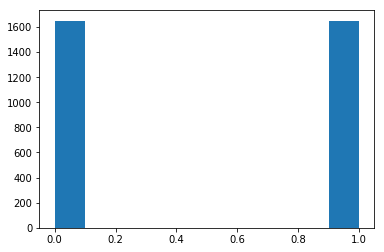

In [264]:
plt.hist(targets)

In [265]:
from sklearn.feature_selection import f_classif,mutual_info_classif

In [266]:
scores = mutual_info_classif(fdf,targets)

Text(0.5, 1.0, 'Mutual Information Feature Selection')

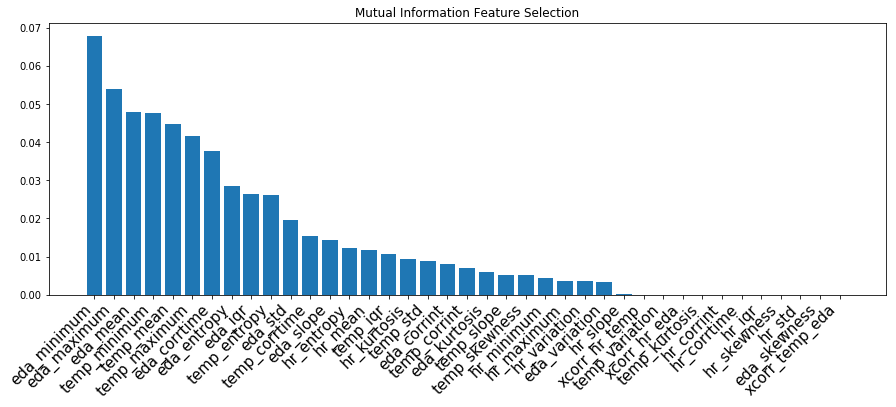

In [267]:
plt.figure(figsize=(15,5))
sortidx = np.argsort(-scores)
plt.bar(fdf.columns[sortidx],height=scores[sortidx],)
plt.xticks(rotation=45, ha='right',fontsize=15);
plt.title('Mutual Information Feature Selection')

In [268]:
pca_fdf = fdf[fdf.columns[sortidx][0:10]]


#targets = np.asarray(bin_likerts)[~nanidx]

## 2-Class SVM

In [269]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product
from mlxtend.plotting import plot_decision_regions


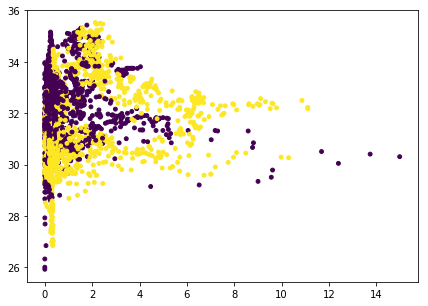

In [270]:
X = np.asarray(pca_fdf[['eda_minimum','temp_minimum']])
t = np.asarray(targets)

sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,t, test_size = 0.1, shuffle = True)


plt.figure(figsize = (7,5))
plt.scatter(pca_fdf['eda_minimum'], pca_fdf['temp_minimum'], s = 15, c = targets, cmap = 'viridis')

In [316]:
clf = SVC(kernel = 'rbf',  probability = True, C = 100, gamma = 10)

In [317]:
clf.fit(X_train,y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [318]:
clf.score(X_test,y_test)

0.7478787878787879

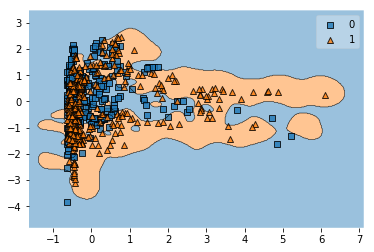

In [319]:
plot_decision_regions(X_test, y_test, clf = clf);

Text(0.5, 0.1, 'AUC = 0.80')

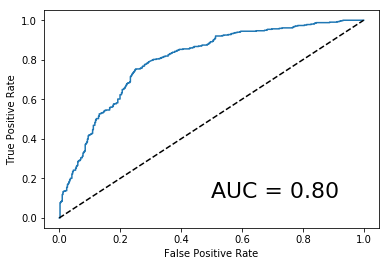

In [323]:
probs = clf.predict_proba(X_test)[:,1]

fpr,tpr,_ = roc_curve(y_test,probs)
plt.plot(fpr,tpr)
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.5,0.1,'AUC = %.2f'%roc_auc_score(y_test,probs), fontsize = 22)

##### warning: reckless experimentation below

## All Features (PCA)

## Logistic Regression

In [35]:
X = np.asarray(fdf)
t = np.asarray(targets)
encoder = preprocessing.OneHotEncoder(categories = 'auto')
t_onehot = encoder.fit_transform(t.reshape(-1,1)).toarray()

sc = preprocessing.MinMaxScaler()
X_scaled = sc.fit_transform(X)

In [36]:
clf = LogisticRegression(solver = 'lbfgs', max_iter = 1000000, tol = 0.000001)

In [37]:
clf.fit(X,t)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-06, verbose=0,
                   warm_start=False)

In [38]:
clf.score(X,t)

0.6166616130988478

In [39]:
roc_auc_score(t,clf.predict_proba(X)[:,1])

0.660996225912033

In [40]:
lr_fpr,lr_tpr,_ = roc_curve(t,clf.predict_proba(X)[:,1])

Text(0, 0.5, 'True Positive Rate')

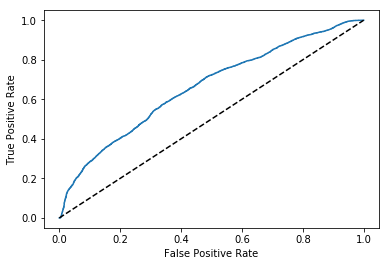

In [41]:
plt.plot(lr_fpr,lr_tpr)
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## SGD Classifier

In [173]:
X = np.asarray(pca_fdf)
t = np.asarray(targets)
encoder = preprocessing.OneHotEncoder(categories = 'auto')
t_onehot = encoder.fit_transform(t.reshape(-1,1)).toarray()

sc = preprocessing.MinMaxScaler()
X_scaled = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,t, test_size = 0.1, shuffle = True)

In [174]:
sgd = SGDClassifier(loss = 'log', max_iter = 1000, verbose = True, tol = 1e-10, n_iter_no_change = 100,\
                   penalty = 'elasticnet')

In [175]:
sgd.fit(X_train,y_train)

-- Epoch 1
Norm: 11.46, NNZs: 9, Bias: 3.094113, T: 11872, Avg. loss: 1.657116
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 9.02, NNZs: 8, Bias: 2.731827, T: 23744, Avg. loss: 0.784824
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 7.36, NNZs: 9, Bias: 2.473218, T: 35616, Avg. loss: 0.726833
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 6.32, NNZs: 7, Bias: 2.424267, T: 47488, Avg. loss: 0.700790
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 5.73, NNZs: 7, Bias: 2.182923, T: 59360, Avg. loss: 0.691774
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 5.84, NNZs: 8, Bias: 1.750636, T: 71232, Avg. loss: 0.684735
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 5.67, NNZs: 8, Bias: 1.856679, T: 83104, Avg. loss: 0.680041
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 5.18, NNZs: 8, Bias: 1.592443, T: 94976, Avg. loss: 0.676581
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 4.96, NNZs: 8, Bias: 1.847138, T: 106848, Avg. loss: 0.671175
Total training t

Norm: 3.60, NNZs: 8, Bias: 1.631254, T: 1472128, Avg. loss: 0.655832
Total training time: 0.20 seconds.
-- Epoch 125
Norm: 3.61, NNZs: 8, Bias: 1.600279, T: 1484000, Avg. loss: 0.656163
Total training time: 0.20 seconds.
-- Epoch 126
Norm: 3.57, NNZs: 8, Bias: 1.636894, T: 1495872, Avg. loss: 0.655799
Total training time: 0.20 seconds.
-- Epoch 127
Norm: 3.59, NNZs: 8, Bias: 1.612716, T: 1507744, Avg. loss: 0.655591
Total training time: 0.21 seconds.
-- Epoch 128
Norm: 3.55, NNZs: 8, Bias: 1.681902, T: 1519616, Avg. loss: 0.655884
Total training time: 0.21 seconds.
-- Epoch 129
Norm: 3.57, NNZs: 8, Bias: 1.645018, T: 1531488, Avg. loss: 0.655714
Total training time: 0.21 seconds.
-- Epoch 130
Norm: 3.57, NNZs: 8, Bias: 1.661388, T: 1543360, Avg. loss: 0.655716
Total training time: 0.21 seconds.
-- Epoch 131
Norm: 3.54, NNZs: 8, Bias: 1.683737, T: 1555232, Avg. loss: 0.655612
Total training time: 0.21 seconds.
-- Epoch 132
Norm: 3.57, NNZs: 8, Bias: 1.616102, T: 1567104, Avg. loss: 0.65

Norm: 3.53, NNZs: 8, Bias: 1.600064, T: 3110464, Avg. loss: 0.654877
Total training time: 0.40 seconds.
-- Epoch 263
Norm: 3.53, NNZs: 8, Bias: 1.612714, T: 3122336, Avg. loss: 0.655079
Total training time: 0.40 seconds.
-- Epoch 264
Norm: 3.53, NNZs: 8, Bias: 1.611515, T: 3134208, Avg. loss: 0.655316
Total training time: 0.41 seconds.
-- Epoch 265
Norm: 3.54, NNZs: 8, Bias: 1.591785, T: 3146080, Avg. loss: 0.655372
Total training time: 0.41 seconds.
-- Epoch 266
Norm: 3.53, NNZs: 8, Bias: 1.609849, T: 3157952, Avg. loss: 0.655097
Total training time: 0.41 seconds.
-- Epoch 267
Norm: 3.51, NNZs: 8, Bias: 1.643577, T: 3169824, Avg. loss: 0.655215
Total training time: 0.41 seconds.
-- Epoch 268
Norm: 3.52, NNZs: 8, Bias: 1.624707, T: 3181696, Avg. loss: 0.655372
Total training time: 0.41 seconds.
-- Epoch 269
Norm: 3.51, NNZs: 8, Bias: 1.642358, T: 3193568, Avg. loss: 0.655358
Total training time: 0.41 seconds.
-- Epoch 270
Norm: 3.53, NNZs: 8, Bias: 1.612664, T: 3205440, Avg. loss: 0.65

Norm: 3.50, NNZs: 8, Bias: 1.647117, T: 4772544, Avg. loss: 0.655055
Total training time: 0.60 seconds.
-- Epoch 403
Norm: 3.51, NNZs: 8, Bias: 1.619976, T: 4784416, Avg. loss: 0.655041
Total training time: 0.61 seconds.
-- Epoch 404
Norm: 3.51, NNZs: 8, Bias: 1.625287, T: 4796288, Avg. loss: 0.654964
Total training time: 0.61 seconds.
-- Epoch 405
Norm: 3.53, NNZs: 8, Bias: 1.580933, T: 4808160, Avg. loss: 0.655001
Total training time: 0.61 seconds.
-- Epoch 406
Norm: 3.50, NNZs: 8, Bias: 1.641876, T: 4820032, Avg. loss: 0.654986
Total training time: 0.61 seconds.
-- Epoch 407
Norm: 3.50, NNZs: 8, Bias: 1.643005, T: 4831904, Avg. loss: 0.655064
Total training time: 0.61 seconds.
-- Epoch 408
Norm: 3.50, NNZs: 8, Bias: 1.635784, T: 4843776, Avg. loss: 0.655058
Total training time: 0.61 seconds.
-- Epoch 409
Norm: 3.50, NNZs: 8, Bias: 1.639196, T: 4855648, Avg. loss: 0.654656
Total training time: 0.61 seconds.
-- Epoch 410
Norm: 3.51, NNZs: 8, Bias: 1.625504, T: 4867520, Avg. loss: 0.65

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=100, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=1e-10,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [176]:
sgd.score(X_test,y_test)

0.6037878787878788

Text(0, 0.5, 'True Positive Rate')

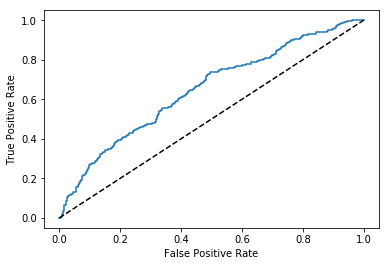

In [177]:
probs = sgd.predict_proba(X_test)[:,1]
rf_fpr,rf_tpr,_ = roc_curve(y_test,probs)
plt.plot(rf_fpr,rf_tpr)
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Random Forest

In [42]:
X = np.asarray(pca_fdf)
t = np.asarray(targets)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,t, test_size = 0.1, shuffle = False)
rf =  RandomForestClassifier(n_estimators = 100)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
rf.score(X_test,y_test)

0.5348484848484848

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score

In [58]:
probs = rf.predict_proba(X_test)[:,1]

In [59]:
rf_fpr,rf_tpr,_ = roc_curve(y_test,probs)

Text(0, 0.5, 'True Positive Rate')

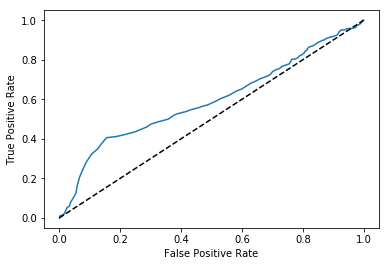

In [60]:
plt.plot(rf_fpr,rf_tpr)
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [61]:
roc_auc_score(y_test,probs)

0.5946944444444444

## Unsupervised Learning

## Gaussian Mixture Model

In [71]:
from sklearn.mixture import BayesianGaussianMixture

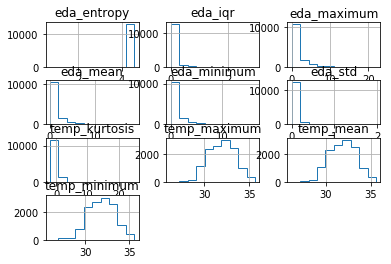

In [715]:
pca_fdf.hist(histtype = 'step');

In [716]:
X = np.asarray(pca_fdf)

In [717]:
gmm = BayesianGaussianMixture(n_components = 2, covariance_type = 'full', max_iter = 1000)

In [718]:
gmm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=2, n_init=1,
                        random_state=None, reg_covar=1e-06, tol=0.001,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

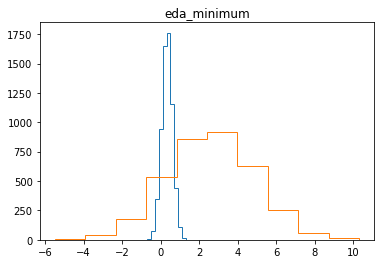

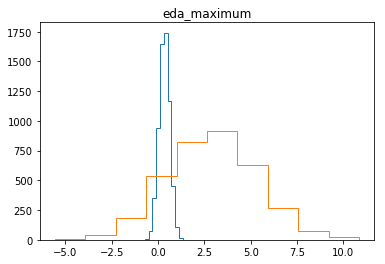

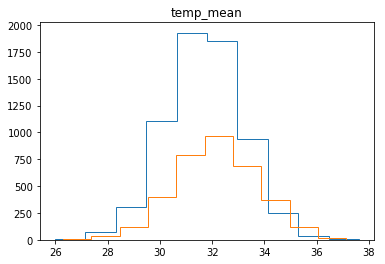

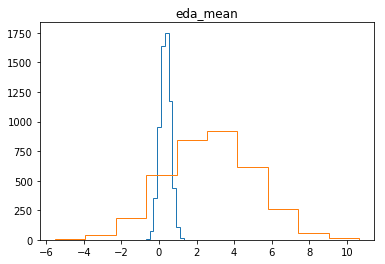

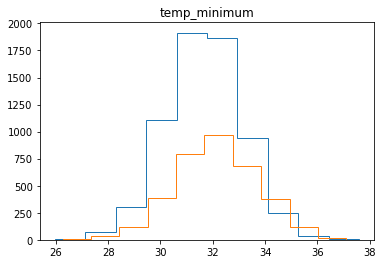

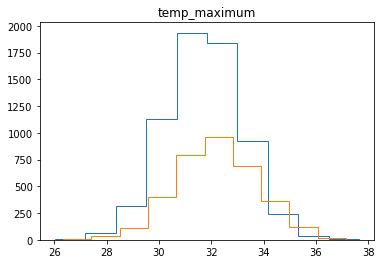

In [387]:
sample,classes = gmm.sample(10000)

for i in range(6):
    plt.figure()
    plt.hist(sample[:,i][classes == 0], histtype = 'step')
    plt.hist(sample[:,i][classes == 1], histtype = 'step')
    plt.title(pca_fdf.columns[i])

## Neural Network

In [473]:
import astroNN.nn.layers as annlayers
import astroNN.nn.losses as annlosses
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

In [478]:
X = np.asarray(pca_fdf)
t = np.asarray(targets)
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

t_cat = tf.compat.v1.keras.utils.to_categorical(t)

X_train,X_test,y_train,y_test = train_test_split(X_scaled, t_cat, test_size = 0.2, shuffle = False)

In [491]:
reg = 1.7e-1

def nn():
    x = Input(shape=(X_train[0].shape[0],))
    y = Dense(10,activation='relu', kernel_regularizer = l2(reg))(x)
    #y = annlayers.MCDropout(0.1)(y)
    y = Dense(10,activation='relu', kernel_regularizer = l2(reg))(y)
    out = Dense(2,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'binary_crossentropy', \
                  metrics = ['accuracy'])
    return model

history = np.asarray([]);
vhistory = np.asarray([]);
model = nn()
#model.load_weights('bayesnet.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_82 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_83 (Dense)             (None, 2)                 22        
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________
None


In [498]:
for i in tqdm(range(20)): 
    print('Training meta-batch %i'%i)
    
    n_epochs = 10
    
    batch = 64
    
    h = model.fit(X_train,y_train, epochs = n_epochs, verbose = 1, batch_size = batch, validation_data = (X_test,y_test))
    history = np.append(history, h.history['acc'])
    vhistory = np.append(vhistory, h.history['val_acc'])





















  0%|          | 0/20 [00:00<?, ?it/s]

Training meta-batch 0
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 26us/step - loss: 0.6989 - acc: 0.5744 - val_loss: 0.6899 - val_acc: 0.6992
Epoch 2/10
2640/2640 [==============================] - 0s 26us/step - loss: 0.6987 - acc: 0.5754 - val_loss: 0.6884 - val_acc: 0.6939
Epoch 3/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6983 - acc: 0.5765 - val_loss: 0.6883 - val_acc: 0.7114
Epoch 4/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6981 - acc: 0.5788 - val_loss: 0.6874 - val_acc: 0.7462
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6978 - acc: 0.5729 - val_loss: 0.6861 - val_acc: 0.7091
Epoch 6/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6971 - acc: 0.5795 - val_loss: 0.6858 - val_acc: 0.7583
Epoch 7/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6966 - acc: 0.5710 - val_loss: 0.6857 - va





















  5%|▌         | 1/20 [00:00<00:10,  1.90it/s]

Training meta-batch 1
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 21us/step - loss: 0.6950 - acc: 0.5699 - val_loss: 0.6821 - val_acc: 0.7765
Epoch 2/10
2640/2640 [==============================] - 0s 20us/step - loss: 0.6945 - acc: 0.5691 - val_loss: 0.6827 - val_acc: 0.7614
Epoch 3/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6941 - acc: 0.5686 - val_loss: 0.6811 - val_acc: 0.7720
Epoch 4/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6936 - acc: 0.5680 - val_loss: 0.6815 - val_acc: 0.7705
Epoch 5/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6931 - acc: 0.5657 - val_loss: 0.6806 - val_acc: 0.7667
Epoch 6/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6927 - acc: 0.5669 - val_loss: 0.6784 - val_acc: 0.7803
Epoch 7/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6927 - acc: 0.5659 - val_loss: 0.6769 - va





















 10%|█         | 2/20 [00:01<00:09,  1.90it/s]

Training meta-batch 2
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 21us/step - loss: 0.6908 - acc: 0.5676 - val_loss: 0.6762 - val_acc: 0.7848
Epoch 2/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6902 - acc: 0.5672 - val_loss: 0.6758 - val_acc: 0.7841
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6897 - acc: 0.5689 - val_loss: 0.6767 - val_acc: 0.7788
Epoch 4/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6894 - acc: 0.5665 - val_loss: 0.6746 - val_acc: 0.7705
Epoch 5/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6893 - acc: 0.5720 - val_loss: 0.6775 - val_acc: 0.7727
Epoch 6/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6888 - acc: 0.5710 - val_loss: 0.6735 - val_acc: 0.7682
Epoch 7/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6889 - acc: 0.5678 - val_loss: 0.6731 - va





















 15%|█▌        | 3/20 [00:01<00:08,  1.94it/s]

Training meta-batch 3
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6868 - acc: 0.5712 - val_loss: 0.6721 - val_acc: 0.7871
Epoch 2/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6869 - acc: 0.5667 - val_loss: 0.6691 - val_acc: 0.7568
Epoch 3/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6864 - acc: 0.5729 - val_loss: 0.6730 - val_acc: 0.7841
Epoch 4/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6863 - acc: 0.5706 - val_loss: 0.6696 - val_acc: 0.7727
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6857 - acc: 0.5712 - val_loss: 0.6720 - val_acc: 0.7841
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6853 - acc: 0.5659 - val_loss: 0.6710 - val_acc: 0.7826
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6852 - acc: 0.5686 - val_loss: 0.6698 - va





















 20%|██        | 4/20 [00:01<00:07,  2.01it/s]

Training meta-batch 4
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6841 - acc: 0.5699 - val_loss: 0.6697 - val_acc: 0.7788
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6839 - acc: 0.5714 - val_loss: 0.6662 - val_acc: 0.7591
Epoch 3/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6835 - acc: 0.5739 - val_loss: 0.6691 - val_acc: 0.7902
Epoch 4/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6833 - acc: 0.5687 - val_loss: 0.6673 - val_acc: 0.7856
Epoch 5/10
2640/2640 [==============================] - 0s 20us/step - loss: 0.6831 - acc: 0.5720 - val_loss: 0.6699 - val_acc: 0.7773
Epoch 6/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6828 - acc: 0.5737 - val_loss: 0.6677 - val_acc: 0.7894
Epoch 7/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6826 - acc: 0.5642 - val_loss: 0.6656 - va





















 25%|██▌       | 5/20 [00:02<00:07,  2.01it/s]

Training meta-batch 5
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6819 - acc: 0.5686 - val_loss: 0.6664 - val_acc: 0.7886
Epoch 2/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6815 - acc: 0.5746 - val_loss: 0.6662 - val_acc: 0.7758
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6813 - acc: 0.5686 - val_loss: 0.6639 - val_acc: 0.7591
Epoch 4/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6816 - acc: 0.5710 - val_loss: 0.6627 - val_acc: 0.7727
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6817 - acc: 0.5765 - val_loss: 0.6632 - val_acc: 0.7553
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6806 - acc: 0.5678 - val_loss: 0.6652 - val_acc: 0.7902
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6806 - acc: 0.5687 - val_loss: 0.6640 - va





















 30%|███       | 6/20 [00:02<00:06,  2.04it/s]

Training meta-batch 6
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6798 - acc: 0.5765 - val_loss: 0.6605 - val_acc: 0.7841
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6795 - acc: 0.5708 - val_loss: 0.6619 - val_acc: 0.7848
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6795 - acc: 0.5674 - val_loss: 0.6633 - val_acc: 0.7826
Epoch 4/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6795 - acc: 0.5737 - val_loss: 0.6618 - val_acc: 0.7856
Epoch 5/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6789 - acc: 0.5646 - val_loss: 0.6626 - val_acc: 0.7917
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6789 - acc: 0.5650 - val_loss: 0.6606 - val_acc: 0.7833
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6789 - acc: 0.5771 - val_loss: 0.6624 - va





















 35%|███▌      | 7/20 [00:03<00:06,  2.08it/s]

Training meta-batch 7
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6789 - acc: 0.5684 - val_loss: 0.6631 - val_acc: 0.7758
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6779 - acc: 0.5680 - val_loss: 0.6582 - val_acc: 0.7538
Epoch 3/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6787 - acc: 0.5856 - val_loss: 0.6609 - val_acc: 0.7894
Epoch 4/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6788 - acc: 0.5682 - val_loss: 0.6586 - val_acc: 0.7826
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6778 - acc: 0.5720 - val_loss: 0.6602 - val_acc: 0.7864
Epoch 6/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6779 - acc: 0.5714 - val_loss: 0.6578 - val_acc: 0.7674
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6780 - acc: 0.5710 - val_loss: 0.6583 - va





















 40%|████      | 8/20 [00:03<00:05,  2.12it/s]

Training meta-batch 8
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6771 - acc: 0.5750 - val_loss: 0.6618 - val_acc: 0.7795
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6769 - acc: 0.5687 - val_loss: 0.6569 - val_acc: 0.7545
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6774 - acc: 0.5797 - val_loss: 0.6583 - val_acc: 0.7864
Epoch 4/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6772 - acc: 0.5682 - val_loss: 0.6645 - val_acc: 0.7682
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6769 - acc: 0.5669 - val_loss: 0.6572 - val_acc: 0.7795
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6771 - acc: 0.5792 - val_loss: 0.6657 - val_acc: 0.7462
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6771 - acc: 0.5718 - val_loss: 0.6604 - va





















 45%|████▌     | 9/20 [00:04<00:05,  2.14it/s]

Training meta-batch 9
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6765 - acc: 0.5678 - val_loss: 0.6596 - val_acc: 0.7826
Epoch 2/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6758 - acc: 0.5706 - val_loss: 0.6547 - val_acc: 0.7712
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6758 - acc: 0.5718 - val_loss: 0.6600 - val_acc: 0.7788
Epoch 4/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6756 - acc: 0.5735 - val_loss: 0.6589 - val_acc: 0.7803
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6757 - acc: 0.5695 - val_loss: 0.6571 - val_acc: 0.7826
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6757 - acc: 0.5701 - val_loss: 0.6531 - val_acc: 0.6652
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6756 - acc: 0.5744 - val_loss: 0.6572 - va





















 50%|█████     | 10/20 [00:04<00:04,  2.15it/s]

Training meta-batch 10
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6751 - acc: 0.5722 - val_loss: 0.6551 - val_acc: 0.7856
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6755 - acc: 0.5718 - val_loss: 0.6551 - val_acc: 0.7795
Epoch 3/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6748 - acc: 0.5737 - val_loss: 0.6567 - val_acc: 0.7780
Epoch 4/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6751 - acc: 0.5741 - val_loss: 0.6531 - val_acc: 0.7591
Epoch 5/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6748 - acc: 0.5716 - val_loss: 0.6573 - val_acc: 0.7780
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6748 - acc: 0.5750 - val_loss: 0.6602 - val_acc: 0.7765
Epoch 7/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6746 - acc: 0.5672 - val_loss: 0.6535 - v





















 55%|█████▌    | 11/20 [00:05<00:04,  2.15it/s]

Training meta-batch 11
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6740 - acc: 0.5773 - val_loss: 0.6571 - val_acc: 0.7795
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6741 - acc: 0.5731 - val_loss: 0.6514 - val_acc: 0.7614
Epoch 3/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6736 - acc: 0.5680 - val_loss: 0.6541 - val_acc: 0.7818
Epoch 4/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6740 - acc: 0.5684 - val_loss: 0.6550 - val_acc: 0.7886
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6737 - acc: 0.5710 - val_loss: 0.6527 - val_acc: 0.7864
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6734 - acc: 0.5727 - val_loss: 0.6528 - val_acc: 0.7826
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6739 - acc: 0.5680 - val_loss: 0.6532 - v





















 60%|██████    | 12/20 [00:05<00:03,  2.15it/s]

Training meta-batch 12
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6732 - acc: 0.5701 - val_loss: 0.6530 - val_acc: 0.7864
Epoch 2/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6731 - acc: 0.5705 - val_loss: 0.6587 - val_acc: 0.7712
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6736 - acc: 0.5725 - val_loss: 0.6608 - val_acc: 0.7667
Epoch 4/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6743 - acc: 0.5691 - val_loss: 0.6540 - val_acc: 0.7788
Epoch 5/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6727 - acc: 0.5703 - val_loss: 0.6496 - val_acc: 0.7402
Epoch 6/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6727 - acc: 0.5795 - val_loss: 0.6532 - val_acc: 0.7833
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6726 - acc: 0.5710 - val_loss: 0.6561 - v





















 65%|██████▌   | 13/20 [00:06<00:03,  2.16it/s]

Training meta-batch 13
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6723 - acc: 0.5750 - val_loss: 0.6483 - val_acc: 0.7220
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6728 - acc: 0.5701 - val_loss: 0.6498 - val_acc: 0.7742
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6715 - acc: 0.5763 - val_loss: 0.6555 - val_acc: 0.7780
Epoch 4/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6729 - acc: 0.5748 - val_loss: 0.6557 - val_acc: 0.7788
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6718 - acc: 0.5716 - val_loss: 0.6496 - val_acc: 0.7788
Epoch 6/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6719 - acc: 0.5759 - val_loss: 0.6531 - val_acc: 0.7780
Epoch 7/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6719 - acc: 0.5759 - val_loss: 0.6550 - v





















 70%|███████   | 14/20 [00:06<00:02,  2.16it/s]

Training meta-batch 14
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6716 - acc: 0.5722 - val_loss: 0.6495 - val_acc: 0.7674
Epoch 2/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6716 - acc: 0.5695 - val_loss: 0.6522 - val_acc: 0.7795
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6719 - acc: 0.5723 - val_loss: 0.6528 - val_acc: 0.7803
Epoch 4/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6713 - acc: 0.5746 - val_loss: 0.6531 - val_acc: 0.7773
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6715 - acc: 0.5697 - val_loss: 0.6500 - val_acc: 0.7811
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6712 - acc: 0.5759 - val_loss: 0.6532 - val_acc: 0.7788
Epoch 7/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6707 - acc: 0.5691 - val_loss: 0.6503 - v





















 75%|███████▌  | 15/20 [00:07<00:02,  2.17it/s]

Training meta-batch 15
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6722 - acc: 0.5718 - val_loss: 0.6527 - val_acc: 0.7795
Epoch 2/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6710 - acc: 0.5741 - val_loss: 0.6481 - val_acc: 0.7750
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6712 - acc: 0.5659 - val_loss: 0.6537 - val_acc: 0.7803
Epoch 4/10
2640/2640 [==============================] - 0s 23us/step - loss: 0.6720 - acc: 0.5706 - val_loss: 0.6479 - val_acc: 0.7720
Epoch 5/10
2640/2640 [==============================] - 0s 24us/step - loss: 0.6708 - acc: 0.5735 - val_loss: 0.6499 - val_acc: 0.7879
Epoch 6/10
2640/2640 [==============================] - 0s 20us/step - loss: 0.6714 - acc: 0.5750 - val_loss: 0.6490 - val_acc: 0.7712
Epoch 7/10
2640/2640 [==============================] - 0s 22us/step - loss: 0.6710 - acc: 0.5792 - val_loss: 0.6601 - v





















 80%|████████  | 16/20 [00:07<00:01,  2.06it/s]

Training meta-batch 16
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 23us/step - loss: 0.6720 - acc: 0.5727 - val_loss: 0.6497 - val_acc: 0.7879
Epoch 2/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6705 - acc: 0.5761 - val_loss: 0.6515 - val_acc: 0.7788
Epoch 3/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6704 - acc: 0.5710 - val_loss: 0.6491 - val_acc: 0.7689
Epoch 4/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6701 - acc: 0.5735 - val_loss: 0.6538 - val_acc: 0.7780
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6709 - acc: 0.5735 - val_loss: 0.6588 - val_acc: 0.7523
Epoch 6/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6716 - acc: 0.5746 - val_loss: 0.6521 - val_acc: 0.7879
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6706 - acc: 0.5731 - val_loss: 0.6453 - v





















 85%|████████▌ | 17/20 [00:08<00:01,  2.06it/s]

Training meta-batch 17
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6698 - acc: 0.5735 - val_loss: 0.6513 - val_acc: 0.7788
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6708 - acc: 0.5670 - val_loss: 0.6505 - val_acc: 0.7795
Epoch 3/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6700 - acc: 0.5655 - val_loss: 0.6475 - val_acc: 0.7682
Epoch 4/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6699 - acc: 0.5708 - val_loss: 0.6485 - val_acc: 0.7818
Epoch 5/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6696 - acc: 0.5714 - val_loss: 0.6489 - val_acc: 0.7803
Epoch 6/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6695 - acc: 0.5699 - val_loss: 0.6528 - val_acc: 0.7833
Epoch 7/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6700 - acc: 0.5669 - val_loss: 0.6490 - v





















 90%|█████████ | 18/20 [00:08<00:00,  2.09it/s]

Training meta-batch 18
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6698 - acc: 0.5676 - val_loss: 0.6466 - val_acc: 0.7477
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6697 - acc: 0.5689 - val_loss: 0.6457 - val_acc: 0.7644
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6695 - acc: 0.5699 - val_loss: 0.6506 - val_acc: 0.7788
Epoch 4/10
2640/2640 [==============================] - 0s 21us/step - loss: 0.6692 - acc: 0.5714 - val_loss: 0.6534 - val_acc: 0.7773
Epoch 5/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6711 - acc: 0.5633 - val_loss: 0.6544 - val_acc: 0.7735
Epoch 6/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6704 - acc: 0.5695 - val_loss: 0.6501 - val_acc: 0.7788
Epoch 7/10
2640/2640 [==============================] - 0s 18us/step - loss: 0.6692 - acc: 0.5731 - val_loss: 0.6492 - v





















 95%|█████████▌| 19/20 [00:09<00:00,  2.09it/s]

Training meta-batch 19
Train on 2640 samples, validate on 660 samples
Epoch 1/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6692 - acc: 0.5723 - val_loss: 0.6518 - val_acc: 0.7795
Epoch 2/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6693 - acc: 0.5741 - val_loss: 0.6502 - val_acc: 0.7818
Epoch 3/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6695 - acc: 0.5706 - val_loss: 0.6498 - val_acc: 0.7788
Epoch 4/10
2640/2640 [==============================] - 0s 16us/step - loss: 0.6690 - acc: 0.5699 - val_loss: 0.6450 - val_acc: 0.7508
Epoch 5/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6699 - acc: 0.5729 - val_loss: 0.6555 - val_acc: 0.7652
Epoch 6/10
2640/2640 [==============================] - 0s 19us/step - loss: 0.6694 - acc: 0.5720 - val_loss: 0.6522 - val_acc: 0.7674
Epoch 7/10
2640/2640 [==============================] - 0s 17us/step - loss: 0.6700 - acc: 0.5780 - val_loss: 0.6534 - v





















100%|██████████| 20/20 [00:09<00:00,  2.11it/s]

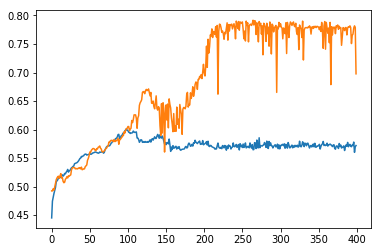

In [499]:
plt.plot(history)
plt.plot(vhistory)

In [500]:
preds = model.predict(X_test)

In [501]:
preds_proba = model.predict(X_test)[:,1]

In [502]:
fpr,tpr,_ = roc_curve(y_test[:,1], preds_proba)

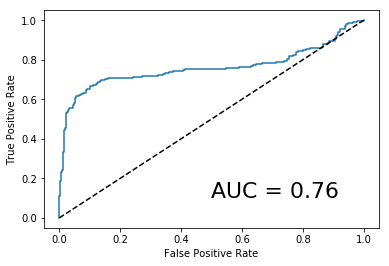

In [503]:
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.text(0.5,0.1,'AUC = %.2f'%roc_auc_score(y_test[:,1],preds_proba), fontsize = 22);

In [428]:
thresholds = np.linspace(0,1,100)
scores = [];
for threshold in thresholds:
    bin_preds = preds_proba > threshold
    scores.append(np.mean(bin_preds == y_test[:,1]))

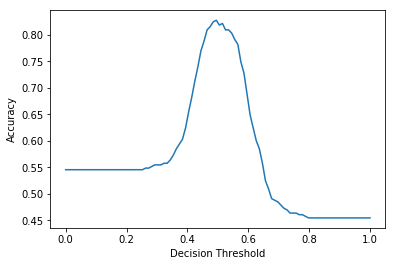

In [429]:
plt.plot(thresholds, scores)
plt.ylabel('Accuracy')
plt.xlabel('Decision Threshold');


## Support Vector Machine

In [310]:
X = np.asarray(pca_fdf[['eda_minimum','temp_minimum']])
t = np.asarray(targets)

sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(X)


In [311]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,t)

#### Hyperparameter Tuning

In [314]:
Cs = [.001,.01,.1,1, 100,1000];
gs = [100,10,1, 0.1, 0.001];
scores = [];

hyperparams = np.vstack((product(np.array(Cs),np.array(gs))))

/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [315]:
for hp in tqdm(hyperparams):
    C = hp[0]
    g = hp[1]
    print('C = %i, gamma = %.6f'%(C,g))
    svc = SVC(gamma = g, C = C, kernel = 'rbf')
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    scores.append(score)
    print('Score = %.3f'%score)

  3%|▎         | 1/30 [00:00<00:05,  5.79it/s]

C = 0, gamma = 100.000000
Score = 0.498
C = 0, gamma = 10.000000


 10%|█         | 3/30 [00:00<00:04,  6.21it/s]

Score = 0.498
C = 0, gamma = 1.000000
Score = 0.498
C = 0, gamma = 0.100000


 17%|█▋        | 5/30 [00:00<00:03,  6.45it/s]

Score = 0.498
C = 0, gamma = 0.001000
Score = 0.498
C = 0, gamma = 100.000000


 23%|██▎       | 7/30 [00:01<00:03,  6.43it/s]

Score = 0.498
C = 0, gamma = 10.000000
Score = 0.613
C = 0, gamma = 1.000000


 30%|███       | 9/30 [00:01<00:03,  6.44it/s]

Score = 0.648
C = 0, gamma = 0.100000
Score = 0.636
C = 0, gamma = 0.001000


 37%|███▋      | 11/30 [00:01<00:02,  6.45it/s]

Score = 0.498
C = 0, gamma = 100.000000
Score = 0.661
C = 0, gamma = 10.000000


 43%|████▎     | 13/30 [00:01<00:02,  6.67it/s]

Score = 0.676
C = 0, gamma = 1.000000
Score = 0.670
C = 0, gamma = 0.100000


 50%|█████     | 15/30 [00:02<00:02,  6.66it/s]

Score = 0.641
C = 0, gamma = 0.001000
Score = 0.498
C = 1, gamma = 100.000000


 57%|█████▋    | 17/30 [00:02<00:01,  6.92it/s]

Score = 0.750
C = 1, gamma = 10.000000
Score = 0.716
C = 1, gamma = 1.000000


 63%|██████▎   | 19/30 [00:02<00:01,  7.06it/s]

Score = 0.692
C = 1, gamma = 0.100000
Score = 0.658
C = 1, gamma = 0.001000


 67%|██████▋   | 20/30 [00:03<00:01,  6.93it/s]

Score = 0.628
C = 100, gamma = 100.000000


 70%|███████   | 21/30 [00:03<00:02,  4.17it/s]

Score = 0.714
C = 100, gamma = 10.000000


 73%|███████▎  | 22/30 [00:03<00:02,  3.84it/s]

Score = 0.748
C = 100, gamma = 1.000000


 77%|███████▋  | 23/30 [00:04<00:01,  3.95it/s]

Score = 0.697
C = 100, gamma = 0.100000


 83%|████████▎ | 25/30 [00:04<00:01,  4.72it/s]

Score = 0.673
C = 100, gamma = 0.001000
Score = 0.634
C = 1000, gamma = 100.000000


 87%|████████▋ | 26/30 [00:07<00:03,  1.01it/s]

Score = 0.712
C = 1000, gamma = 10.000000


 90%|█████████ | 27/30 [00:08<00:03,  1.13s/it]

Score = 0.747
C = 1000, gamma = 1.000000


 93%|█████████▎| 28/30 [00:09<00:01,  1.02it/s]

Score = 0.688
C = 1000, gamma = 0.100000


100%|██████████| 30/30 [00:09<00:00,  1.60it/s]

Score = 0.691
C = 1000, gamma = 0.001000
Score = 0.632


In [24]:
svc = SVC(gamma = 0.1, C = 10000, tol = 0.01, kernel = 'rbf')
svc.fit(X_train,y_train)
svc.score(X_test,y_test)

0.6946274708565636